## 风格样式迁移

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


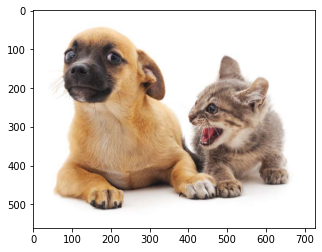

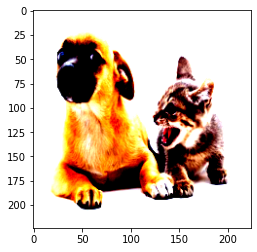

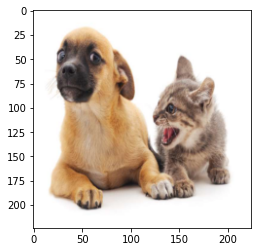

In [2]:
# 定义前处理和后处理函数，对输入图像进行标准化以及还原
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])
def preprocess(img, image_shape):   # 预处理
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)    # 为了增加一个batch维度方便小批量训练

def postprocess(img):     # 后处理
    img = img[0].to(rgb_std.device)   # 去掉batch维度
    # 由于图像打印函数要求每个像素的浮点数值在0到1之间，我们对⼩于0和⼤于1的值分别取0和1
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))  # 要转成PIL图片不然打印不了
    # 因为这个transforms方法只能接收c×h×w格式，所以要把img permute回去

plt.figure(1)
img_path = "catdog.jpg"
img = Image.open(img_path) 
plt.imshow(img)      # 显示原图
img_shape = (224, 224)
img_trans = preprocess(img, img_shape)
img2 = postprocess(img_trans)
plt.figure(2)
plt.imshow(img_trans.squeeze(0).permute(1,2,0))    # 显示变换后的图像
plt.figure(3)
plt.imshow(img2)    # 打印复原后的图像

content_img = Image.open('catdog.jpg')
style_img = Image.open('autumn-oak.jpg')

### 抽取特征

In [3]:
# 为了抽取图像的内容特征和⻛格特征，我们可以选择VGG⽹络中某些层的输出。
# ⼀般来说，越靠近输⼊层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息。
# 为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，即内容层，来输出图像的内容特征。
# 我们还从VGG中选择不同层的输出来匹配局部和全局的⻛格，这些图层也称为⻛格层

# VGG19里面一个卷积块包含两个conv2d层
# VGG⽹络使⽤了5个卷积块。我们选择第四卷积块的最后⼀个卷积层作为内容层，选择每个卷积块的第⼀个卷积层作为⻛格层。
pretrained_net = torchvision.models.vgg19(pretrained=True)
# print(pretrained_net)
style_layers, content_layers = [0, 5, 10, 19, 28], [25]    # 保留我们想要的前29层即可
net = nn.Sequential(*[pretrained_net.features[i]    # 这个features好像是VGG类自带的参数，返回的是模型
            for i in range(max(content_layers + style_layers) + 1)])
print(net)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
# 给定输⼊X，如果我们简单地调⽤前向传播net(X)，只能获得最后⼀层的输出
# 由于我们还需要中间层的输出，因此这⾥我们逐层计算，并保留内容层和⻛格层的输出

def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

def get_contents(content_img, image_shape, device):    # 抽取内容图像特征
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(style_img, image_shape, device):      # 抽取风格图像特征
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

# 因为在训练时⽆须改变预训练的VGG的模型参数，所以我们可以在训练开始之前就提取出内容特征和⻛格特征。
# 由于合成图像是⻛格迁移所需迭代的模型参数，我们只能在训练过程中通过调⽤extract_features函数来抽取合成图像的内容特征和⻛格特征

### 定义损失函数
- **内容损失、⻛格损失和全变分损失3部分组成**

In [5]:
# 内容损失通过平⽅误差函数衡量合成图像与内容图像在内容特征上的差异
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离⽬标：
    # 这是⼀个规定的值，⽽不是⼀个变量
    return torch.square(Y_hat-Y.detach()).mean()    
    # detach这个函数是相当于复制一次Y，但是不用影响原先变量的变化，且返回的值不可导


# ⻛格损失与内容损失类似，也通过平⽅误差函数衡量合成图像与⻛格图像在⻛格上的差异
'''
为了表达⻛格层输出的⻛格，我们先通过extract_features函数计算⻛格层的输出。
假设该输出的样本数为1，通道数为c，⾼和宽分别为h和w，我们可以将此输出转换为矩阵X，其有c⾏和hw/c列。
这个矩阵可以被看作是由c个⻓度为hw/c的向量x1.....xc组合⽽成的。其中向量xi代表了通道i上的⻛格特征
'''
# 首先定义格拉姆矩阵，矩阵中每一个元素即i通道上特征向量和j通道上特征向量的内积，表达风格相关性
# 同时为了避免矩阵中元素值过大从而影响损失值，矩阵中元素值要除以矩阵中元素的个数
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]   # numel函数返回tensor中的元素总数
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)        

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

# 通常我们训练出来的图像中含有大量噪声：⼀种常⻅的去噪⽅法是全变分去噪
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

# 定义总的损失函数：⻛格转移的损失函数是内容损失、⻛格损失和总变化损失的加权和。
# 通过调节这些权重超参数，我们可以权衡合成图像在保留内容、迁移⻛格以及去噪三⽅⾯的相对重要性
content_weight, style_weight, tv_weight = 1, 1e3, 10
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、⻛格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

### 初始化合成图像

In [6]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

# 下面的函数创建了合成图像的模型实例，并将其初始化为图像X
# ⻛格图像在各个⻛格层的格拉姆矩阵styles_Y_gram将在训练前预先计算好
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer
    

### 训练模型

In [7]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, 
                                        contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                        float(sum(styles_l)), float(tv_l)])
    return X

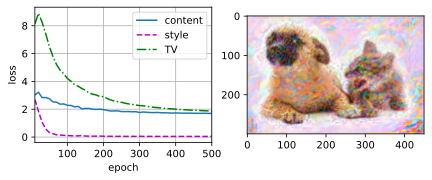

In [8]:
device, image_shape = "cpu", (300, 450)   # 事实上风格迁移不太需要GPU，CPU都够了
net = net.to(device)
content_X, contents_Y = get_contents(content_img, image_shape, device)
_, styles_Y = get_styles(style_img, image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)